# Challenge Teamcore 

Para este desafio se espera que trabajes con los datos del archivo `data.csv` que se encuentra junto con este archivo. Te recomendamos copiar este archivo y la data en tu propio Drive para poder editarlo y trabajar en el. 

### Objetivo

Realizar un forecast de la venta de productos afectados por promociones.

### Descripcion:

El set de datos con el que trabjará consiste en 1000 series de tiempo de distintos productos. La idea es poder predecir de manera precisa cuanto es la venta de un producto cuando se encuentra en un periodo de promocion (como recomendacion está esta [lectura sugerida](https://krannert.purdue.edu/masters/business-analytics-and-information-management/student-experiences/experiential-learning/2018/an-analytical-approach-for-understanding-promotion-effects-on-demand-and-improving-profits.php?) la cual sirve de referencia, pero no es necesario que se basen en ella ni que necesarimente usen las metodologias y features que aparecen ahi). Los datos son series de tiempo del mundo real, por lo tanto los datos pueden venir sucios, ruidosos, etc. 
Usted tiene la libertad total para utilizar cualquier modelo, ténica de extracción de feature, etc, para lograr cumplir el objetivo, además de ser capaz de presentar sus resultados de la manera mas clara posible

### Data:
* Columnas:
    * ID: Corresponde al identificador del producto
    * cadena: cadena a la que pertenece el producto
    * fecha: Dia en el que fue extraido el dato
    * venta_unidades_dia: Unidades que se vendieron ese dia
    * venta_clp_dia: Dinero total que se ganó por las unidades vendidas 
    * is_promo. Booleano que es 0 cuando el producto no estuvo en promoción y 1 cuando si lo estuvo:
    * promo_ID: Identificador de la promocion (un prodcuto puede estar promocionados muchas veces o de manera seguida con diferentes promociones)

### Fecha limite:

### Ouput: 
Enviar jupyter con resultados a 

## Respuesta

Primero que todo se considera relevante mencionar que el enfoque a utilizar dependerá del objetivo principal del pronóstico solicitado.Se estima que éste puede ser analizado desde dos perspectivas en términos generales: desde la perspectiva de gestión logística o cadena de suministro, o desde el punto de vista de la estrategia o inteligencia de negocios.

Desde la primera perspectiva mencionada se considera que hacer el pronóstico de las unidades a vender es más adecuado mientras que si el objetivo principal es el análisis desde el punto de vista de la estrategia o inteligencia de negocios se considera más razonable hacer el pronóstico de las ventas (utilidad por ventas - no está claro segúna la descripción si es utilidad o solo ingreso, pero para efectos de el presente trabajo se considerará como utilidad - ). Dado que no se especifican las características de las promociones, las unidades vendidas pueden incrementar de forma drástica con promociones muy atractivas para los consumidores mientras que los ingresos no necesariamente. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import progressbar
import pickle
from datetime import timedelta
from scipy.stats import mannwhitneyu

from merf.merf import MERF
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from hypopt import GridSearch




PATH = 'data.csv'
df = pd.read_csv(PATH)
df.fecha = pd.to_datetime(df.fecha, errors = 'raise')

df.info()

INFO     [utils.py:141] NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251358 entries, 0 to 251357
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ID                  251358 non-null  int64         
 1   cadena              251358 non-null  int64         
 2   fecha               251358 non-null  datetime64[ns]
 3   venta_unidades_dia  245834 non-null  float64       
 4   venta_clp_dia       245834 non-null  float64       
 5   is_promo            251358 non-null  int64         
 6   promo_ID            113728 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 13.4+ MB


In [2]:
df.describe()

ID         cadena  venta_unidades_dia  venta_clp_dia  \
count  251358.000000  251358.000000       245834.000000   2.458340e+05   
mean      168.374780       3.109179          175.213314   3.386545e+05   
std       111.990448       1.786093          714.243545   9.322262e+05   
min         0.000000       0.000000            0.000000   0.000000e+00   
25%        76.000000       2.000000           19.000000   4.275384e+04   
50%       156.000000       3.000000           54.000000   1.105579e+05   
75%       251.000000       5.000000          130.000000   2.670640e+05   
max       412.000000       6.000000        66093.000000   8.978288e+07   

            is_promo  
count  251358.000000  
mean        0.474542  
std         0.499352  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

1: Non-null, 0: otherwise


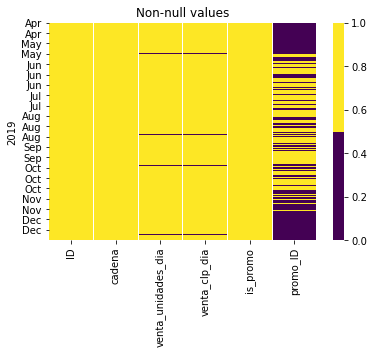

In [3]:
aux = df.sort_values('fecha')
aux['date_fmt'] = aux.fecha.apply(lambda date: date.strftime('%b'))
aux = aux.drop('fecha', axis = 1)
aux = aux.set_index('date_fmt')
sns.heatmap(1-aux.isnull(), cmap = plt.get_cmap('viridis',2))
plt.ylabel('2019')
plt.title('Non-null values')
print('1: Non-null, 0: otherwise')

La base de datos está ordenada solo por fecha por lo que hay que considerar que la distribución de los campos faltantes en promo_id puede estar asociado también a los campos de producto y cadena.

In [4]:
df.set_index(['ID', 'cadena','fecha'], inplace = True)
df.sort_index(level = [0,1,2],inplace = True)

In [5]:
unique_id = df.index.get_level_values(0).drop_duplicates()
unique_cadena = df.index.get_level_values(1).drop_duplicates()

print('La base de datos posee un total de {} productos y {} cadenas.'.format(len(unique_id), len(unique_cadena)))
print('Considerando una serie por producto y cadena, hay un total de {} series en la base de datos'.format(len(df.index.droplevel(2).drop_duplicates())))                                                                 

La base de datos posee un total de 413 productos y 7 cadenas.
Considerando una serie por producto y cadena, hay un total de 1000 series en la base de datos


Imputación de filas para la continuidad de cada serie para analizar datos faltantes en función de la fecha y permitir la utilización de criterios de imputación.

**El ciclo iterativo es por cada serie, no por cada fila**.
El método pandas.DataFrame.groupby sólo posee métodos aggregate(),filter(), transform(), y apply() lo que hace imposible la aplicación del método  pandas.DataFrame.asfreq en un objeto groupby para la imputación de fechas faltantes por serie. Esto se hace con el objetivo de poder completar las series bajo algún criterio en caso de decidir utilizar algún método que requiera de series continuas.

In [6]:
uncomplete = []
series = df.index.droplevel(2).drop_duplicates()
i = 0

pbar = progressbar.ProgressBar(maxval=1000,widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
pbar.start()
for product, chain in series:
    aux_panel = df.loc[(product,chain,slice(None)),:]
    aux_panel.index = aux_panel.index.droplevel([0,1])
    aux_panel = aux_panel.asfreq('D', fill_value = np.nan)
    aux_panel.index = pd.MultiIndex.from_product([[product],[chain], aux_panel.index])
    if i ==0 : df_01 = aux_panel
    else: df_01 = pd.concat([df_01, aux_panel])
    uncomplete.append(aux_panel.drop(level = 2, labels = df.loc[(product,chain,slice(None)),:].
                                                  index.droplevel([0,1])).index)
    i = i+1
    pbar.update(i)
pbar.finish()
df_01.rename_axis(['ID','cadena','fecha'], inplace = True)
print('{} filas correspondientes a fechas faltantes fueron añadidas.'.format(df_01.shape[0]-df.shape[0]))

6867 filas correspondientes a fechas faltantes fueron añadidas.


1: Non-null, 0: otherwise


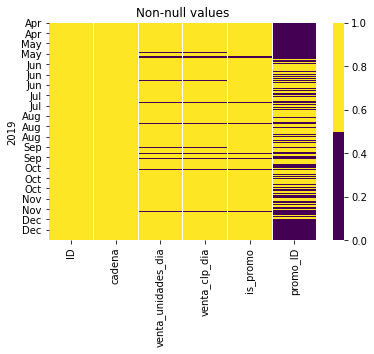

In [7]:
aux = df_01.copy()
aux.reset_index(inplace = True)
aux.sort_values('fecha', inplace = True)
aux['date_fmt'] = aux.fecha.apply(lambda date: date.strftime('%b'))
aux = aux.drop('fecha', axis = 1)
aux = aux.set_index('date_fmt')
sns.heatmap(1-aux.isnull(), cmap = plt.get_cmap('viridis',2))
plt.ylabel('2019')
plt.title('Non-null values')
print('1: Non-null, 0: otherwise')

In [8]:
df_01.head(5)

venta_unidades_dia  venta_clp_dia  is_promo promo_ID
ID cadena fecha                                                           
0  0      2019-04-09                38.0        81434.0       0.0      NaN
          2019-04-10                64.0       137152.0       0.0      NaN
          2019-04-11                67.0       143581.0       0.0      NaN
          2019-04-12                55.0       117865.0       0.0      NaN
          2019-04-13               108.0       231444.0       0.0      NaN

In [9]:
df_01.groupby('is_promo').venta_clp_dia.describe().round(0)

count      mean        std  min      25%       50%       75%  \
is_promo                                                                    
0.0       132078.0  283824.0   823802.0  0.0  33658.0   94075.0  231923.0   
1.0       113756.0  402317.0  1040467.0  0.0  55575.0  130232.0  314306.0   

                 max  
is_promo              
0.0       56992717.0  
1.0       89782876.0

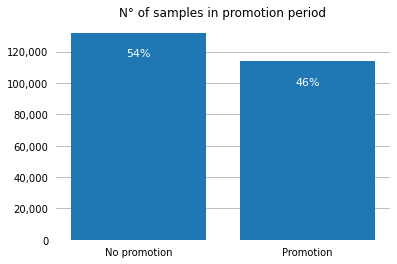

In [10]:
bars = plt.bar(['No promotion','Promotion'],df_01.groupby('is_promo').count().venta_clp_dia,zorder = 3 )
total = df_01.groupby('is_promo').count().venta_clp_dia.sum()
for bar in bars:
    height = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 15000,'{:.0f}%'.format(int(height)/total*100), 
                 ha='center', color='w', fontsize=11)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.tick_params(left = False)
plt.tick_params(bottom = False)

plt.grid(axis = 'y', zorder = 3)

plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('N° of samples in promotion period');

In [11]:
aux = df_01.groupby('is_promo').venta_clp_dia.describe()
print('El promedio de ventas en período de promoción es un {:.2f}% mayor al promedio de ventas en períodos normales.'.
     format(aux['mean'].pct_change().iloc[1]*100))

stat = mannwhitneyu(df_01.loc[df_01.is_promo == 0,'venta_clp_dia'],df_01.loc[df_01.is_promo == 1,'venta_clp_dia'])
print(stat)

El promedio de ventas en período de promoción es un 41.75% mayor al promedio de ventas en períodos normales.
MannwhitneyuResult(statistic=6429772097.0, pvalue=0.0)


Si bien la diferencia de medias es significativa, esto no necesariamente indica que este aumento se debe particularmente al efecto de las promociones. Este efecto puede ser causado por la coincidencia temporal de las promociones con segmentos estacionales de alta demanda o debido a que promociones recientes estén afectando a productos con efectos significativos de tendencia, por lo que en estos casos, el aumento de ventas estaría más asociado a efectos temporales de la serie.

Visualización de series por producto

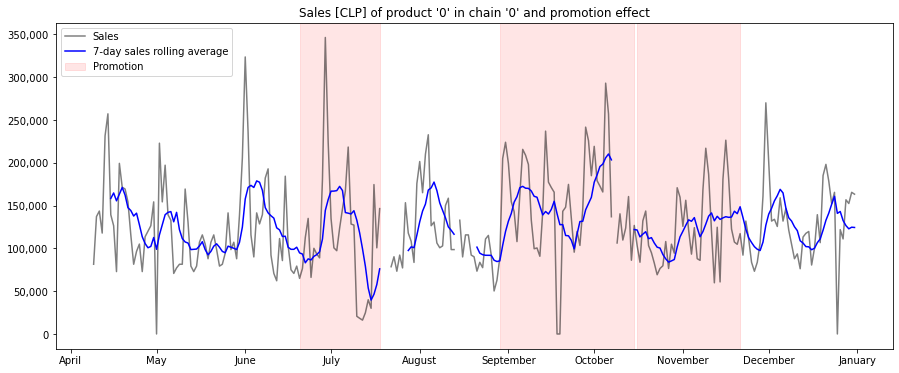

In [12]:
#plt.style.use('seaborn-white')
fig, ax  = plt.subplots(figsize = (15,6))



aux = df_01.loc[(series[0][0], series[0][1], slice(None)),:]
aux.index = aux.index.droplevel([0,1])

ax.plot(aux.index, aux.venta_clp_dia, 'k', label = 'Sales', alpha = 0.5)
rolling_avg = aux.rolling(window = 7).mean()
ax.plot(rolling_avg.index, rolling_avg.venta_clp_dia,'b-', label = '7-day sales rolling average')
# ax.plot(aux.loc[aux.is_promo ==1].index,aux.loc[aux.is_promo ==1,'venta_clp_dia'], 'rx')
#aux.plot(ax = ax1, color = 'r')


#ax.set_ylabel('Sales [clp]')
month_fmt = mpl.dates.DateFormatter('%B')
ax.xaxis.set_major_formatter(month_fmt)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
promo = aux.is_promo.shift()-aux.is_promo
for i in range(promo[promo==1].shape[0]):
    if i == 0: ax.axvspan(promo[promo==1].index[i], promo[promo==-1].index[i], alpha=0.1, color='red', label ='Promotion')
    else: ax.axvspan(promo[promo==1].index[i], promo[promo==-1].index[i], alpha=0.1, color='red')
    
plt.legend()
plt.title('Sales [CLP] of product \'{}\' in chain \'{}\' and promotion effect'.format(series[0][0],series[0][1]));



In [13]:
# pbar = progressbar.ProgressBar(maxval=1000,widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# pbar.start()
# j = 0
# for serie in series: 
    
#     plt.close()
#     fig, ax  = plt.subplots(figsize = (15,6))

#     aux = df_01.loc[(serie[0], serie[1], slice(None)),:]
#     aux.index = aux.index.droplevel([0,1])

#     ax.plot(aux.index, aux.venta_clp_dia, 'k', label = 'Sales', alpha = 0.5)
#     rolling_avg = aux.rolling(window = 7).mean()
#     ax.plot(rolling_avg.index, rolling_avg.venta_clp_dia,'b-', label = '7-day sales rolling average')


#     #ax.set_ylabel('Sales [clp]')
#     month_fmt = mpl.dates.DateFormatter('%B')
#     ax.xaxis.set_major_formatter(month_fmt)
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#     promo = aux.is_promo.shift()-aux.is_promo
#     for i in range(promo[promo==1].shape[0]):
#         if promo[promo==1].shape[0] == 0: break
#         if i == 0: 
#             try:ax.axvspan(promo[promo==1].index[i], promo[promo==-1].index[i], alpha=0.1, color='red', label ='Promotion period')
#             except: ax.axvspan(promo[promo==1].index[i], aux.index[-1], alpha=0.1, color='red', label = 'Promotion period')
#         else: 
#             try:ax.axvspan(promo[promo==1].index[i], promo[promo==-1].index[i], alpha=0.1, color='red')
#             except: ax.axvspan(promo[promo==1].index[i], aux.index[-1], alpha=0.1, color='red')

#     plt.legend()
#     plt.title('Sales [CLP] of product \'{}\' in chain \'{}\' and promotion effect'.format(serie[0],serie[1]));
    
#     plt.savefig('Individual series\individual serie{},{}.png'.format(serie[0],serie[1]))
#     j = j+1
#     pbar.update(j)
# pbar.finish()

In [14]:
# products = df_01.index.droplevel([1,2]).drop_duplicates()
# pbar = progressbar.ProgressBar(maxval=1000,widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# pbar.start()
# j = 0
# for product in products:
#     chains = df_01.loc[(product, slice(None),slice(None)),:].index.droplevel([0,2]).drop_duplicates()
#     plt.close()
#     fig, ax = plt.subplots(figsize = (15,6))
#     for chain in chains:
#         aux = df_01.loc[(product,chain, slice(None)),'venta_clp_dia']
#         aux.index = aux.index.droplevel([0,1])
#         ax.plot(aux.index, aux, label = 'chain {}'.format(chain))
#     plt.title('Sales [CLP] of product \'{}\''.format(product))
#     plt.legend()
#     month_fmt = mpl.dates.DateFormatter('%B')
#     ax.xaxis.set_major_formatter(month_fmt)
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#     #plt.ylabel('Sales [clp]')
#     plt.savefig('Product series\product {}.png'.format(product))
#     j = j+1
#     pbar.update(j)
# pbar.finish()

In [15]:
# products = df_01.index.droplevel([1,2]).drop_duplicates()
# pbar = progressbar.ProgressBar(maxval=1000,widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# pbar.start()
# j = 0
# for product in products:
#     chains = df_01.loc[(product, slice(None),slice(None)),:].index.droplevel([0,2]).drop_duplicates()
#     plt.close()
#     fig, ax = plt.subplots(figsize = (15,6))
#     for chain in chains:
#         aux = df_01.loc[(product,chain, slice(None)),'venta_clp_dia'].rolling(window = 7).mean()
#         aux.index = aux.index.droplevel([0,1])
#         ax.plot(aux.index, aux, label = 'chain {}'.format(chain))
#     plt.title('7-day sales rolling average [CLP] of product \'{}\''.format(product))
#     plt.legend()
#     month_fmt = mpl.dates.DateFormatter('%B')
#     ax.xaxis.set_major_formatter(month_fmt)
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#     #plt.ylabel('Sales [clp]')
#     plt.savefig('Product rolling average series\product {}.png'.format(product))
#     j = j+1
#     pbar.update(j)
# pbar.finish()

Se observa que las series están altamente correlacionadas en términos cruzados con sus pares de cadenas diferentes. Junto con esto y a grandes rasgos se observa que la gran mayoría de las series tienden a ser estacionales con un una periodicidad mensual.

Se observa por otra parte que el comportamiento entre productos es bastante heterogéneo.

**VER LOS GRÁFICOS EN LAS CARPETAS RESPECTIVAS**

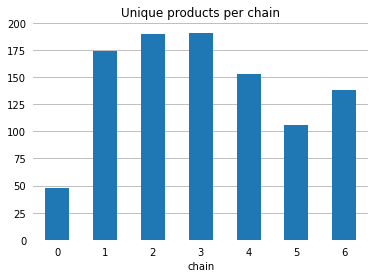

In [16]:
aux = df_01.reset_index()[['cadena','ID']].groupby('cadena')['ID'].nunique()
aux.plot(kind = 'bar', zorder = 3)
plt.xlabel('chain');
plt.tick_params(rotation = 0, bottom = False, left = False)
plt.title('Unique products per chain')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid(axis = 'y', zorder = 0)

In [17]:
print('Hay {} promociones de productos diferentes'.format(df_01.nunique()['promo_ID']))

Hay 59 promociones de productos diferentes


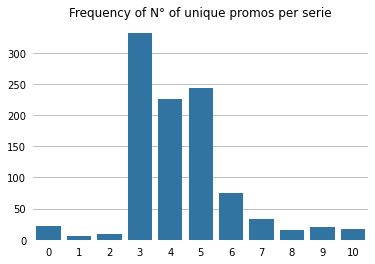

In [18]:
#sns.distplot(df_01.groupby(['ID', 'cadena']).promo_ID.nunique(), kde = False)
sns.countplot(df_01.groupby(['ID', 'cadena']).promo_ID.nunique(), color = '#1F77B4', zorder = 3)

plt.title('Frequency of N° of unique promos per serie');
plt.xlabel(None)
plt.ylabel(None)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.tick_params(bottom = False, left = False)
plt.grid(axis = 'y', zorder = 0)

La mayoría de las series poseen entre 3 y 5 promociones diferentes. Esto es por producto por cadena.

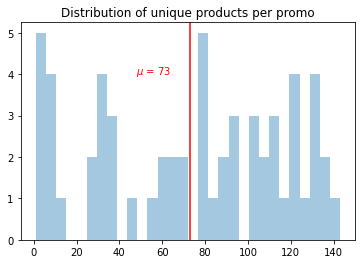

In [19]:
aux = df_01.reset_index().groupby('promo_ID')['ID'].nunique()
sns.distplot(aux, bins = 30, kde = False)
plt.title('Distribution of unique products per promo');
plt.xlabel(None)
plt.axvline(aux.mean(), color = 'r')
plt.text(aux.mean()-17, 4, r'$\mu$ = {:.0f}'.format(aux.mean()), color = 'r',horizontalalignment='center' );

Cada promoción afecta en promedio a 73 productos.

Es importante recalcar que dado que no se tiene el detalle de la promoción, no es posible analizar la elasticidad de la demanda de los productos, por lo se está restringido a un enfoque más generalizado respecto al impacto de las promociones en las ventas.

Dado que es razonable que las promociones tengan impactos diferentes sobre los productos sería ideal poder tener en consideración un efecto único por promoción. Sin embargo, dado que la cardinalidad del conjunto de promociones es alta, la utilización de variables binarias generaría una matriz de diseño bastante espurea, lo que perjudicial para muchos modelos. Una alternativa para utilizar esta información es la utilización de modelos que permitan considerar el efecto de la promoción como un efecto aleatorio, sin embargo, dado el contexto se cree que es más beneficioso utilizar una única variable dicotómica de promoción.

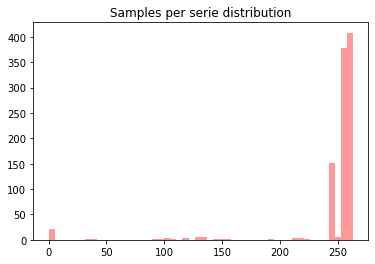

In [20]:
#Número de obs. por serie
sns.distplot(df_01.groupby(['ID','cadena']).count().venta_unidades_dia, kde = False, color = 'r')
plt.xlabel(None)
plt.title('Samples per serie distribution');

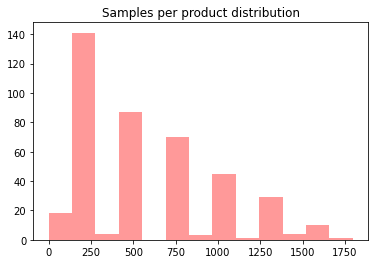

In [21]:
#Número de obs. por serie
sns.distplot(df_01.groupby(['ID']).count().venta_unidades_dia, kde = False, color = 'r')
plt.xlabel(None)
plt.title('Samples per product distribution');

El número de observaciones por serie y por producto es reducido, por lo que utilizar modelos individuales (por serie/producto) debiesen tender a sobreajustarse a menos que sean parametrizados de tal manera de configurar modelos de muy baja varianza y alto sesgo.

Codificación temporal de obervaciones(“Day of Year”, “Month of Year”, ”Day of Week”, etc) debido a la estacionalidad de las series. Dado que la serie corresponde sólo al año 2019, no tiene sentido la codificación de día del año.

In [22]:
#dia semana, dia mes
res = df_01.reset_index()
res.index = df_01.index
df_02 = df_01.copy()

df_02['dia_semana'] = res.fecha.apply(lambda x: x.dayofweek)
df_02['dia_mes'] = res.fecha.apply(lambda x: x.day)
df_02['cadena'] = res.cadena
df_02 = pd.get_dummies(df_02,columns = ['dia_semana','dia_mes','cadena']) 
df_02.drop('promo_ID', axis = 1, inplace = True)
#df_02['is_cero'] = df_02['venta_clp_dia'].apply(lambda x: 1 if x==0 else 0)
df_02.head()                                                 

venta_unidades_dia  venta_clp_dia  is_promo  \
ID cadena fecha                                                     
0  0      2019-04-09                38.0        81434.0       0.0   
          2019-04-10                64.0       137152.0       0.0   
          2019-04-11                67.0       143581.0       0.0   
          2019-04-12                55.0       117865.0       0.0   
          2019-04-13               108.0       231444.0       0.0   

                      dia_semana_0  dia_semana_1  dia_semana_2  dia_semana_3  \
ID cadena fecha                                                                
0  0      2019-04-09             0             1             0             0   
          2019-04-10             0             0             1             0   
          2019-04-11             0             0             0             1   
          2019-04-12             0             0             0             0   
          2019-04-13             0             0             0             0   

                      dia_semana_4  dia_semana_5  dia_semana_6  ...  \
ID cadena fecha                                                 ...   
0  0      2019-04-09             0             0             0  ...   
          2019-04-10             0             0             0  ...   
          2019-04-11             0             0             0  ...   
          2019-04-12             1             0             0  ...   
          2019-04-13             0             1             0  ...   

                      dia_mes_29  dia_mes_30  dia_mes_31  cadena_0  cadena_1  \
ID cadena fecha                                                                
0  0      2019-04-09           0           0           0         1         0   
          2019-04-10           0           0           0         1         0   
          2019-04-11           0           0           0         1         0   
          2019-04-12           0           0           0         1         0   
          2019-04-13           0           0           0         1         0   

                      cadena_2  cadena_3  cadena_4  cadena_5  cadena_6  
ID cadena fecha                                                         
0  0      2019-04-09         0         0         0         0         0  
          2019-04-10         0         0         0         0         0  
          2019-04-11         0         0         0         0         0  
          2019-04-12         0         0         0         0         0  
          2019-04-13         0         0         0         0         0  

[5 rows x 48 columns]

In [23]:
def create_lag(var,shift,df):
    '''This function is only usable in a dataframe with MultIindex ['ID','cadena','fecha'].
    It adds a new column to the input df  with shifted periods (days)'''
    

    aux_series = pd.Series(dtype=np.float)
    for serie in series:
        aux = df.loc[(serie[0],serie[1],slice(None)),var].sort_index().shift(shift) #level 0 index is lost when loc indexing.
        aux_series = pd.concat([aux_series,aux]) #When concatenating, the MultiIndex casts to a tuple index.
        
    aux_series.name = '{} - lag{}'.format(var,shift)
    aux_series.index = pd.MultiIndex.from_tuples(aux_series.index) #Casting back to a MultiIndex
    aux_series.rename_axis(['ID', 'cadena', 'fecha'], inplace = True)
    df = pd.merge(df, aux_series, left_index=True,right_index=True)
    return df

In [24]:
max_lag = 7 #All columns lagged upto 8 cuarters. I.e. 2 years
for lag in range(1,max_lag+1):
    if lag ==1:print('lagging variable \'venta_clp_dia\' {} period'.format(lag))
    else:print('lagging variable \'venta_clp_dia\' {} periods'.format(lag))
    df_02 = create_lag('venta_clp_dia',lag,df_02)    

lagging variable 'venta_clp_dia' 1 period
lagging variable 'venta_clp_dia' 2 periods
lagging variable 'venta_clp_dia' 3 periods
lagging variable 'venta_clp_dia' 4 periods
lagging variable 'venta_clp_dia' 5 periods
lagging variable 'venta_clp_dia' 6 periods
lagging variable 'venta_clp_dia' 7 periods


**Considerar usar One-hot encoder de sklearn en caso de integrar el proceso con pipeline para el pronóstico sistematizado. **

**Precaución con la columna de unidades de venta. Posee multicolinealidad casi perfecta con las ventas.**

Utilizar un enfoque basado en modelos estadísticos tradicionales como modelos ARMA, ARIMA, SARIMA, etc. no es factible ya que para su correcta aplicación es necesario la incorporación de un proceso manual para identificar los modelos apropiados para cada serie además de un proceso iterativo de transformaciones correspondientes de acuerdo con el modelo seleccionado y la serie en cuestión.

El enfoque de descomposición aditiva de las series requiere de series continuas sin valores faltantes. **Precaución con el método de tratamiento de los NAN values (Esto es, data-leakage mediante la filtración del target value en el modelo)**

In [25]:
# #Descomposición aditiva de la serie: y(t) = Level + Trend + Seasonality + Noise
# aux = df_01.loc[(0,0,slice(None)),:].venta_unidades_dia
# #aux = aux.dropna()
# aux.index = aux.index.droplevel([0,1])


# from statsmodels.tsa.seasonal import seasonal_decompose
# serie = aux.sort_index()
# result = seasonal_decompose(serie.fillna(method = 'ffill'), model='additive',period = 30)
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)


# result.plot()
# print(aux.shape[0])

Por el momento no fue factible la utilización de esta técnica en el análisis debido a que una vez entregado el modelo de pronóstico para su uso, no sería posible calcular los valores de nivel, tendencia y estacionalidad para observaciones futuras.

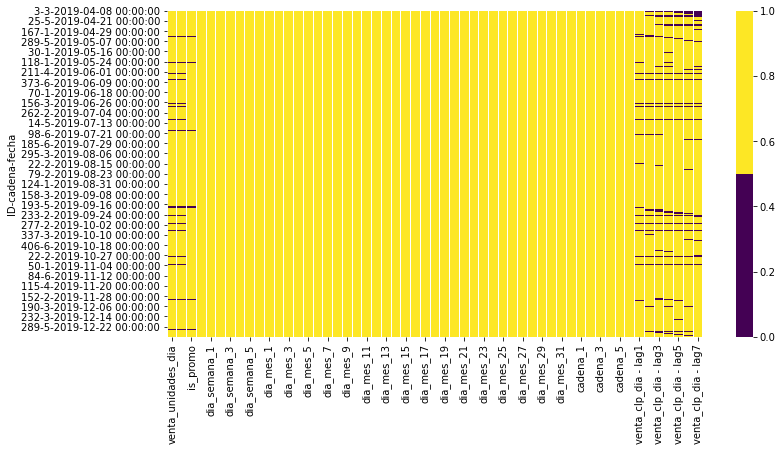

In [26]:
plt.figure(figsize = (12,6))
sns.heatmap(1-df_02.sort_index(level = 2).isnull(), cmap = plt.get_cmap('viridis',2))

Optimización de hyperparámetros de modelo XGBoost y ajuste de modelo de efectos mixtos

Por motivos de recursos computacionales se optimiza el modelo XGBoost y no el modelo de efectos mixtos. Luego el mejor conjunto de hyperparámetros se utiliza para entrenar y testear el modelo final de efectos mixtos.

Para la optimización de hyperparámetros, se utiliza aquel set de hyperparámetros que maximiza el r2 score promedio de validación (datos de Noviembre 2019) de 3 folds del modelo entrenado hasta octubre 2019.

In [27]:
def transform(X,y):
    clusters = X.reset_index()['ID']
    Z = np.ones((X.shape[0], 1))
    return X.reset_index().iloc[:,3:], Z, clusters, y.reset_index().iloc[:,-1]


df_02 = df_02.dropna()

X_train = df_02.loc[(slice(None),slice(None), slice('2019-01-01','2019-10-31')),:].drop(['venta_clp_dia', 'venta_unidades_dia'], axis = 1)
y_train = df_02.loc[(slice(None),slice(None), slice('2019-01-01','2019-10-31')),'venta_clp_dia'] 

X_cv = df_02.loc[(slice(None),slice(None), slice('2019-11-30', None)),:].drop(['venta_clp_dia', 'venta_unidades_dia'], axis = 1)
y_cv = df_02.loc[(slice(None),slice(None), slice('2019-11-30', None)),'venta_clp_dia']


X_test = df_02.loc[(slice(None),slice(None), slice('2019-12-01', None)),:].drop(['venta_clp_dia', 'venta_unidades_dia'], axis = 1)
y_test = df_02.loc[(slice(None),slice(None), slice('2019-12-01', None)),'venta_clp_dia']



# #Calibración de hiperparámetros
# grid = {'n_estimators':[300,500,1000],#,1250,1500], 
#              'max_depth':[3,6,9],#,12,15],
#               'n_jobs':[-1],
#               'learning_rate': np.logspace(0,-4,5),
#        'tree_method': ['gpu_hist']}

# # opt = GridSearch(model = XGBRegressor(),param_grid = grid,parallelize = True)
# # print('Optimizing XGBoost hyperparameters according to specified grid')
# # opt.fit(X_train, y_train, X_cv, y_cv)
# # print('Validation R2 Score for Optimized Parameters: {:.2f}'.format(opt.score(X_cv, y_cv)))
# # print('Best params: {}'.format(opt.best_params))



#Data transform for mixed effect model.
X_train, Z_train, clusters_train, y_train = transform(X_train, y_train)
X_test, Z_test, clusters_test, y_test = transform(X_test, y_test)

# print('Training mixed effects model...')
# #merf = MERF(XGBRegressor(**opt.best_params),max_iterations=20).fit(X_train, Z_train, clusters_train, y_train)


#Manual fitting
# manual_params = {'n_estimators':1000,
#              'max_depth':3,
#               'n_jobs':-1,
#               'learning_rate': 0.05,
#        'tree_method': 'gpu_hist'}

# merf = MERF(XGBRegressor(**manual_params),max_iterations=20).fit(X_train, Z_train, clusters_train, y_train)

#Model evaluation
# preds_train = merf.predict(X_train, Z_train, clusters_train)
# preds_test = merf.predict(X_test, Z_test, clusters_test)
# print('R2 train: {:.2f}\nR2 test: {:.2f}\n'.format(r2_score(y_train,preds_train), r2_score(y_test,preds_test)))

# #Saving model
# pickle.dump(merf, open('merf_model_2.pkl', 'wb'))

# #Saving grid search object
# pickle.dump(opt, open('grid_search_object_2.pkl', 'wb'))


In [28]:
#Load model & gridsearch object
merf = pickle.load(open('merf_model_2.pkl', 'rb')) #R2 train: 0.90
                                                   #R2 test - ex-post: 0.90
    
#opt = pickle.load(open('grid_search_object.pkl', 'rb'))
preds_train = merf.predict(X_train, Z_train, clusters_train)
preds_test = merf.predict(X_test, Z_test, clusters_test)

In [29]:
print('R2 train:                                  {:.2f}'.format(r2_score(y_train,preds_train)))
print('R2 test, ex-post:                          {:.2f}'.format(r2_score(y_train,preds_train)))

aux = (np.abs(y_train-preds_train)/y_train).replace(np.inf,np.nan).dropna()


print('MAPE train:                                {:.2f}'.format(aux.mean()))
print('MAPE train with removal of 1% of outliers: {:.2f}'.format(aux[aux< np.percentile(aux.values, 99)].mean()))


aux = (np.abs(y_test-preds_test)/y_test).replace(np.inf,np.nan).dropna()
print('MAPE test, ex-post:                        {:.2f}'.format(aux.mean()))
print('MAPE test with removal of 1% of outliers:  {:.2f}'.format(aux[aux< np.percentile(aux.values, 99)].mean()))

R2 train:                                  0.90
R2 test, ex-post:                          0.90
MAPE train:                                2.37
MAPE train with removal of 1% of outliers: 0.35
MAPE test, ex-post:                        0.60
MAPE test with removal of 1% of outliers:  0.41


El modelo posee un rendimiento deficiente en un porcentaje mínimo de observaciones a las que se les denominó outliers. Son outliers en términos del pronóstico, no necesariamente de acuerdo con la distribución de la serie a la que pertenece esa observación. Por temas de tiempo no se alcanza a hacer ese análisis, pero es relevante realizarlo en el futuro para así determinar qué causa esta deficiencia en rendimiento para poder corregirla; ya sea mediante un ajuste del modelo a datos filtrados de outliers o incorporación de variables o transformaciones de variables explicativas que puedan hacerlo robusto a estos escenarios.

Pronóstico ex-ante (secuencial mediante ciclo iterativo). Debido a la forma en la que se formuló el modelo (autorregresivo hasta 7 días), para simular un escenario real de aplicación se debe pronosticar un único día en el futuro y luego utilizar este pronóstico como el valor autorregresivo de primer orden en el segundo día y así sucesivamente. Debido a que los errores se comienzan a propagar y amplificar en el futuro, mientras mayor sea el horizonte de pronóstico, menor será el desempeño del modelo.

In [30]:
#Sequential Forecast


# pbar = progressbar.ProgressBar(maxval=X_test.shape[0],
#                                widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# k = 0
# pbar.start()

# #To assure avoiding lexsort issues decreasing performance.
# #df_02 = df_02.sort_index(level = [0,1,2])

# #Step needed to have easy acces to test indexes.
# X_test = df_02.loc[(slice(None),slice(None), slice('2019-12-01', None)),:].drop(['venta_clp_dia', 'venta_unidades_dia'], axis = 1)
# y_test = df_02.loc[(slice(None),slice(None), slice('2019-12-01', None)),'venta_clp_dia']

# X_test_ex_ante = X_test.copy()
# y_test_ex_ante = y_test.copy()

series = df_02.index.droplevel(2).drop_duplicates()

# for serie in series:
#     X_serie = X_test_ex_ante.loc[(serie[0],serie[1],slice(None)),:]
#     y_serie = X_test_ex_ante.loc[(serie[0],serie[1],slice(None)),:]
#     X, Z, clusters, y = transform(X_serie, y_serie) #Formatting to suit merf inputs.

#     for i in range(X.shape[0]):
#         #Formatting to suit one sample prediction.
#         aux_df = pd.DataFrame(X.iloc[i:i+1].values.reshape(1,-1), columns = X.columns)
#         temp = merf.predict(aux_df, Z[i:i+1], pd.Series(clusters[i:i+1]))

#         date_index = X_test_ex_ante.loc[(serie[0], serie[1], slice(None)),:].index.get_level_values(level = 2)[i]

#         for j in range(1,8): #propagation of temp prediction to all lagged periods.
#             try:
#                 X_test_ex_ante.loc[(serie[0],serie[1],date_index + timedelta(days=j)),
#                                    'venta_clp_dia - lag{}'.format(j)] = temp
#                 #print('success!')
#             except Exception as e: 
#                 print(e)
#                 continue
#         k=k+1
#         pbar.update(k)
    
# pbar.finish()

# X_test_ex_ante = X_test_ex_ante.dropna() #Porque se vuelven a añadir filas con valores incompletos que 
# X_test_ex_ante.index = X_test.index      #habían sido removidas anteriormente.

# X_test_ex_ante, Z_test_ex_ante, clusters_test_ex_ante, y = transform(X_test_ex_ante.dropna(), y_test_ex_ante)
# preds_test_ex_ante = merf.predict(X_test_ex_ante, Z_test_ex_ante, clusters_test_ex_ante)


#Saving sequential predictions list
# preds = pd.DataFrame({'y_test_ex_post':preds_test,
#                       'y_test_ex_ante':preds_test_ex_ante,
#                      'y_true': y_test,
#                      'is_promo': X_test.is_promo}, 
#                             index = df_02.loc[(slice(None),slice(None), slice('2019-12-01', None)),:].index)


# preds.to_csv('preds.csv')

In [31]:
preds = pd.read_csv('preds.csv')
preds.fecha = pd.to_datetime(preds.fecha, errors = 'raise')
preds.set_index(['ID','cadena','fecha'], inplace = True)
preds.head()

y_test_ex_post  y_test_ex_ante    y_true  is_promo
ID cadena fecha                                                         
0  0      2019-12-01      202981.660      202981.660  200928.0       0.0
          2019-12-02      124230.650      124230.650  131859.0       0.0
          2019-12-03      105965.320      100542.430  133952.0       0.0
          2019-12-04      106030.266       88097.640  125580.0       0.0
          2019-12-05      110006.195       96905.195  159068.0       0.0

In [32]:
# pbar = progressbar.ProgressBar(maxval=1000,widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# pbar.start()
# j = 0
# for serie in series: 
    
#     plt.close()
#     fig, ax  = plt.subplots(figsize = (15,6))

#     aux = preds.loc[(serie[0], serie[1], slice(None)),:]
#     aux.index = aux.index.droplevel([0,1])

#     ax.plot(aux.index, aux.y_true, 'k', label = 'Sales', alpha = 0.5)
#     ax.plot(aux.index, aux.y_test_ex_post, 'r', label = 'Forecasted Sales (ex-post)', alpha = 0.5)
#     ax.plot(aux.index, aux.y_test_ex_ante, 'b', label = 'Forecasted Sales (ex-ante)', alpha = 0.5)
#     #rolling_avg = aux.rolling(window = 7).mean()
#     #ax.plot(rolling_avg.index, rolling_avg.venta_clp_dia,'b-', label = '7-day sales rolling average')
#     ax.set_xlabel('December')

#     #ax.set_ylabel('Sales [clp]')
#     day_fmt = mpl.dates.DateFormatter('%d')
#     ax.xaxis.set_major_formatter(day_fmt)
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#     promo = aux.is_promo.shift()-aux.is_promo
#     for i in range(promo[promo==1].shape[0]):
#         if promo[promo==1].shape[0] == 0: break
#         if i == 0: 
#             try:ax.axvspan(promo[promo==1].index[i], promo[promo==-1].index[i], alpha=0.1, color='red', label ='Promotion period')
#             except: ax.axvspan(promo[promo==1].index[i], aux.index[-1], alpha=0.1, color='red', label = 'Promotion period')
#         else: 
#             try:ax.axvspan(promo[promo==1].index[i], promo[promo==-1].index[i], alpha=0.1, color='red')
#             except: ax.axvspan(promo[promo==1].index[i], aux.index[-1], alpha=0.1, color='red')

#     plt.legend()
#     plt.title('Sales & Forecasted sales [CLP] of product \'{}\' in chain \'{}\' and promotion effect'.format(serie[0],serie[1]));
    
#     plt.savefig('Out-of-sample model performance\Raw series\individual serie{},{}.png'.format(serie[0],serie[1]))
#     j = j+1
#     pbar.update(j)
# pbar.finish()

In [33]:
# pbar = progressbar.ProgressBar(maxval=1000,widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# pbar.start()
# j = 0
# for serie in series: 
    
#     plt.close()
#     fig, ax  = plt.subplots(figsize = (15,6))

#     aux = preds.loc[(serie[0], serie[1], slice(None)),:]
#     aux.index = aux.index.droplevel([0,1])

#     ax.plot(aux.index, aux.y_true.rolling(window=7).mean(), 'k', label = '7-day Sales rolling average', alpha = 0.5)
#     ax.plot(aux.index, aux.y_test_ex_post.rolling(window=7).mean(), 'r', label = '7-day Forecasted Sales (ex-post) rolling average', alpha = 0.5)
#     ax.plot(aux.index, aux.y_test_ex_ante.rolling(window=7).mean(), 'b', label = '7-day Forecasted Sales (ex-ante) rolling average', alpha = 0.5)
#     #rolling_avg = aux.rolling(window = 7).mean()
#     #ax.plot(rolling_avg.index, rolling_avg.venta_clp_dia,'b-', label = '7-day sales rolling average')
#     ax.set_xlabel('December')

#     #ax.set_ylabel('Sales [clp]')
#     day_fmt = mpl.dates.DateFormatter('%d')
#     ax.xaxis.set_major_formatter(day_fmt)
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#     promo = aux.is_promo.shift()-aux.is_promo
#     for i in range(promo[promo==1].shape[0]):
#         if promo[promo==1].shape[0] == 0: break
#         if i == 0: 
#             try:ax.axvspan(promo[promo==1].index[i], promo[promo==-1].index[i], alpha=0.1, color='red', label ='Promotion period')
#             except: ax.axvspan(promo[promo==1].index[i], aux.index[-1], alpha=0.1, color='red', label = 'Promotion period')
#         else: 
#             try:ax.axvspan(promo[promo==1].index[i], promo[promo==-1].index[i], alpha=0.1, color='red')
#             except: ax.axvspan(promo[promo==1].index[i], aux.index[-1], alpha=0.1, color='red')

#     plt.legend()
#     plt.title('Sales & Forecasted sales [CLP] 7-day rolling average of product \'{}\' in chain \'{}\' and promotion effect'.format(serie[0],serie[1]));
    
#     plt.savefig('Out-of-sample model performance\Rolling averages\individual serie{},{}.png'.format(serie[0],serie[1]))
#     j = j+1
#     pbar.update(j)
# pbar.finish()

In [34]:
r2_ex_ante = []  #coefficient of determination
MAE_ex_ante = [] #mean absolute error. For direct interpretation of the global model.
MAPE_ex_ante = []#To correct MAE heterogeneity across series.

for date in pd.date_range('2019-12-01', end = '2019-12-31'):
    y_true = preds.loc[(slice(None),slice(None),slice('2019-12-01',date.date().strftime('%Y-%m-%d'))), 'y_true']
    y_hat = preds.loc[(slice(None),slice(None),slice('2019-12-01',date.date().strftime('%Y-%m-%d'))), 'y_test_ex_ante']
    
    r2_ex_ante.append(r2_score(y_true,y_hat))
    MAE_ex_ante.append(mean_absolute_error(y_true,y_hat)) 
                                                          
#Dado la heterogeneidad de las series (magnitud de las ventas) la interpretación  
#del MAE puede ser confusa, por lo que la estandarización de esta métrica puede ser de gran utilidad.

    MAPE_ex_ante.append((np.abs(y_true-y_hat)/y_hat).sum()/y_true.shape[0])
    
metrics_ex_ante = pd.DataFrame({'r2':r2_ex_ante,
                               'MAE':MAE_ex_ante,
                               'MAPE': MAPE_ex_ante}, index = pd.date_range('2019-12-01', end = '2019-12-31'))
metrics_ex_ante.rename_axis('Forecast horizon', inplace = True)

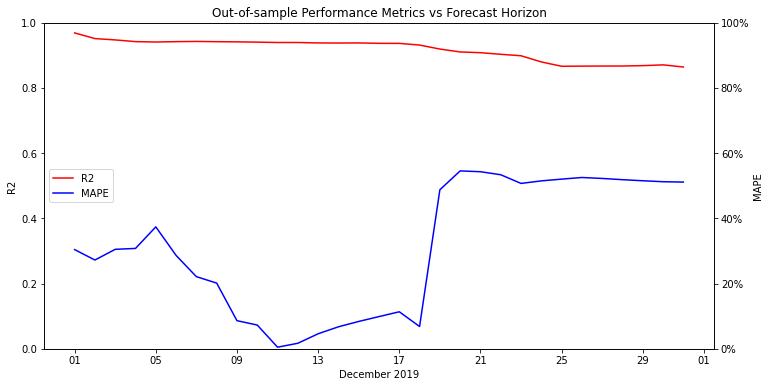

In [35]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.plot(metrics_ex_ante.index, metrics_ex_ante.r2, 'r', label = 'R2')
ax2.plot(metrics_ex_ante.index, metrics_ex_ante.MAPE*100, 'b', label = 'MAPE')

date_fmt = mpl.dates.DateFormatter('%d')
ax1.xaxis.set_major_formatter(date_fmt)

ax1.set_title('Out-of-sample Performance Metrics vs Forecast Horizon')
ax1.set_ylabel('R2')
ax2.set_ylabel('MAPE')

ax1.set_ylim((0,1))
ax2.set_ylim((0,100))


ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

ax1.set_xlabel('December 2019')

plt.legend([ax1.get_children()[0],ax2.get_children()[0]], ['R2', 'MAPE'], loc =6);
#plt.savefig('Out-of-sample_performance_metrics_vs_forecast_horizon.png', dpi =1000)

Como cometario adicional, viendo el comportamiento del modelo, se propone evaluar una metodología que fuerce el pronóstico a un valor positivo. Se estima que una programación manual del output del modelo podría ser suficiente para estos escenarios.

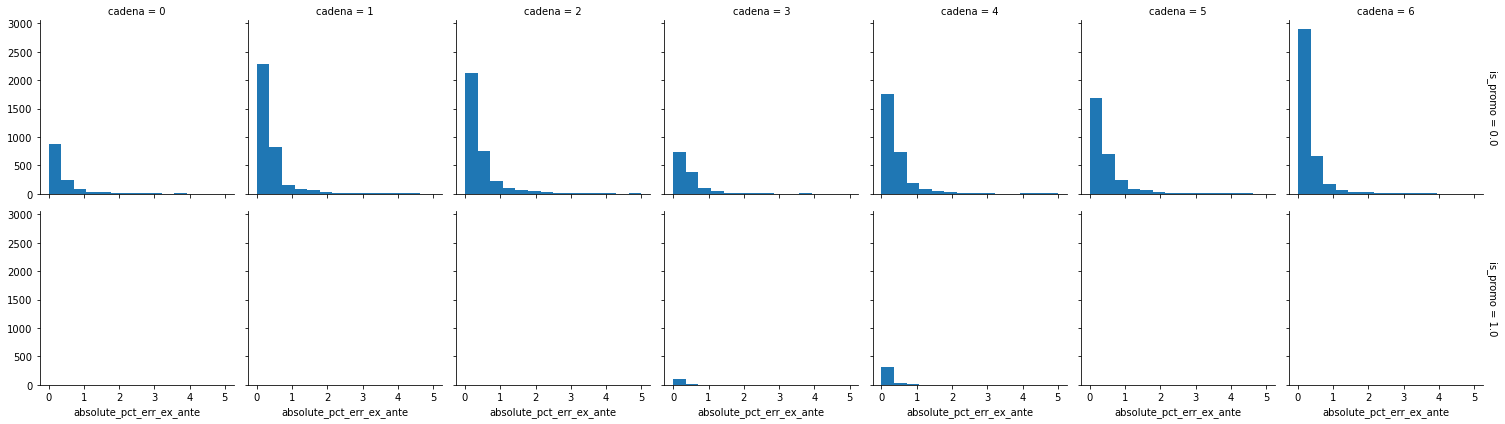

In [36]:
#Desempeño por producto
#Desempeño por cadena
preds['absolute_pct_err_ex_ante'] = (preds.y_true-preds.y_test_ex_ante).apply(np.abs)/preds.y_true
aux = preds.replace(np.inf,np.nan)

grid = sns.FacetGrid(aux.reset_index(), row="is_promo", col="cadena", margin_titles=True)
grid.map(plt.hist, "absolute_pct_err_ex_ante", bins=np.linspace(0, 5, 15));

No hay suficientes observaciones en el set de testeo para evaluar el impacto de las promociones en la precisión del modelo. Por otra parte, se observa que la distribución del error porcentual absoluto es similar en todas las cadenas. Se hará el mismo análisis con los datos de entrenamiento, sin embargo, estos se deben interpretar con cautela.

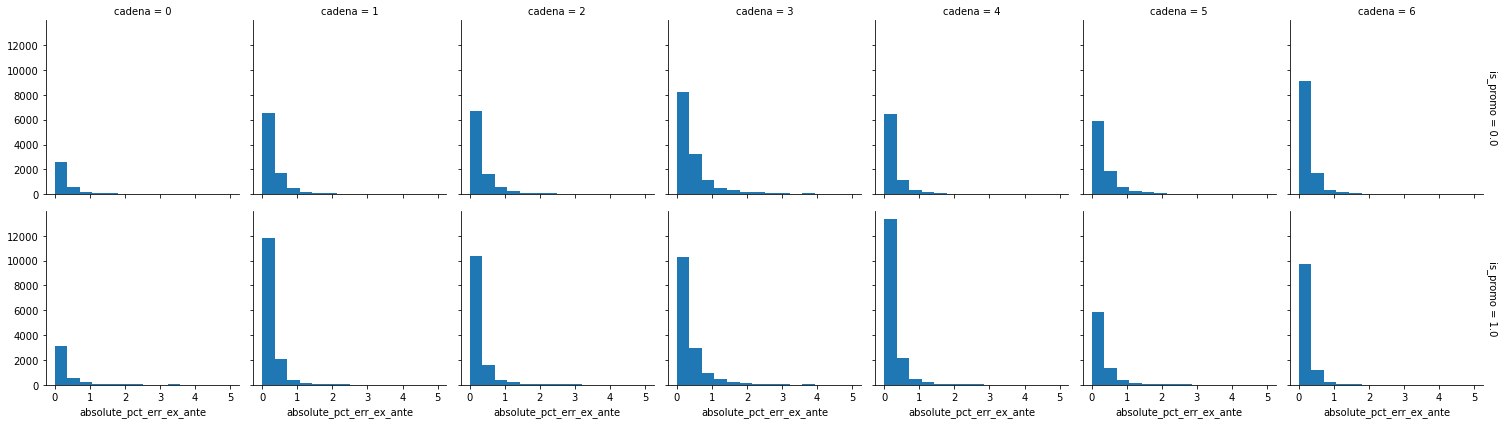

In [37]:
df_train = df_02.loc[(slice(None),slice(None), slice('2019-01-01','2019-10-31')),:].copy()
df_train.loc[(slice(None),slice(None),slice(None)),'y_hat'] = preds_train
df_train.loc[(slice(None),slice(None),slice(None)),'absolute_pct_err_ex_ante'] = (df_train.venta_clp_dia-df_train.y_hat).apply(np.abs)/df_train.venta_clp_dia

grid = sns.FacetGrid(df_train.reset_index(), row="is_promo", col="cadena", margin_titles=True)
grid.map(plt.hist, "absolute_pct_err_ex_ante", bins=np.linspace(0, 5, 15));
# aux.index = df_02.loc[(slice(None),slice(None),slice('2019-04-16','2019-10-31')),:].index

La distribución del error porcentual absoluto es muy similar a la del set de testeo y similar entre las cadenas, por lo que es posible afirmar que el modelo logra generalizar de forma adecuada las tendencias temporales independiente de las cadenas y si está en promoción o no.